In [5647]:
import networkx as nx
import requests
import json
import matplotlib.pyplot as plt


#['app2', 'app5']
#5afdb8cf93beb10025c13f4f
url = 'localhost:5010'
entries = ['app5', 'app6']
rolesa = '593f49be42d3ed97390f25a7'


url = '10.168.20.20:5010'
entries = ['app2']
rolesa = '5afdb8cf93beb10025c13f4f'

In [5648]:
pipeline = [
    {'$match': {'name': {'$in': entries}, 'roles._id': rolesa}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {'name': 1, 'deps': 1, 'deps': 1, 'nodes.name': 1, 'nodes.steps': 1, 'nodes.deps': 1}}
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()
print(data)

{'items': [{'name': 'app2', 'nodes': [{'name': 'app31', 'deps': [{'name': 'app32', 'family': 'Application', 'endpoint': 'rest', '_id': '5b4787bfd7f17a0025e48d41'}, {'name': 'app33', 'family': 'Application', 'endpoint': 'rest', '_id': '5b4787c3d7f17a0025e48d42'}, {'name': 'app34', 'family': 'Application', 'endpoint': 'rest', '_id': '5b4787c7d7f17a0025e48d43'}], 'steps': 2}, {'name': 'app34', 'steps': 3}, {'name': 'app 10', 'deps': [{'name': 'DB - O', 'family': 'Database', 'endpoint': 'rest', '_id': '5b462be6d7f17a0025e48d3a'}], 'steps': 2}, {'name': 'lb3 -add 2', 'steps': 1}, {'name': 'app4', 'deps': [{'name': 'app6', 'family': 'Application', 'endpoint': 'rest', '_id': '5b4535d5d7f17a0025e48d39'}, {'name': 'Db - mysql', 'family': 'Database', 'endpoint': 'rest', '_id': '5b3d1a70d7f17a0025e48d32'}, {'name': 'app20', 'family': 'Application', 'endpoint': 'rest', '_id': '5b465c47d7f17a0025e48d3e'}], 'steps': 0}, {'name': 'app32', 'steps': 3}, {'name': 'DB - O', 'steps': 1}, {'name': 'app1', 

In [5649]:

class BaseNetwork(object):
    def __init__(self, G=nx.DiGraph):
        self.graph = G()
        self.clear_duplicate()

    def create_edge(self, item):
        if 'deps' in item:
            for dps in item['deps']:
                w = item.get('steps', -1)
                self.graph.add_edge(item['name'], dps['name'], weight=w+1)

    def create_node(self, node_id, item, root = False):
        if node_id not in self.duplicate:
            self.graph.add_node(node_id, uid=item.get('_id'), label=item.get('name'), root=root, object=item)
            self.duplicate.append(node_id)

    def make(self, data, i=0):
        for item in data:
            self.create_node(item['name'], item, i is 0)
            
            if 'nodes' in item and len(item['nodes']) > 0:
                self.make(item['nodes'], i+1)
                
            self.create_edge(item)
            
        self.clear_duplicate()   
        return self

    def get_graph(self):
        return self.graph

    def clear_duplicate(self):
        self.duplicate = []
    
class DrawNetwork(object):

    def __init__(self, G):
        self.graph = G
        
    def get_cardials(self):
        return nx.circular_layout(self.graph)
    
    
    def save_svg(self, options, labels):
        #plt.figure(figsize=(4, 4))
        pos = self.get_cardials()

        nx.draw(self.graph, pos, **options)

        labels = nx.get_edge_attributes(self.graph,'weight')
        nx.draw_networkx_edge_labels(self.graph,pos,edge_labels=labels)

        plt.axis('equal')
        plt.show()
        return pos

network = BaseNetwork()
network.make(data.get('items')).get_graph()

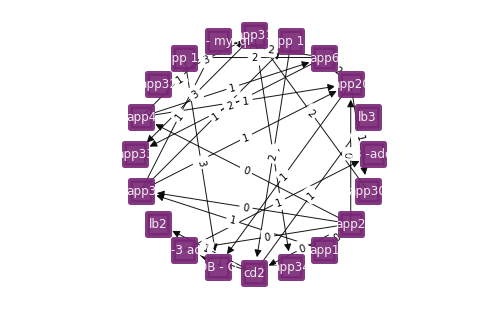

{'lb3 -add 2': array([9.99999981e-01, 1.92722997e-08]), 'lb-3 add': array([-0.58778505, -0.80901709]), 'app20': array([0.80901699, 0.58778525]), 'app6': array([0.58778523, 0.80901701]), 'app31': array([-4.36121782e-08,  1.00000000e+00]), 'app 10': array([-0.58778517,  0.80901701]), 'app 11': array([0.30901697, 0.95105654]), 'app32': array([-0.80901705,  0.58778519]), 'app4': array([-0.95105646,  0.30901705]), 'app33': array([-9.99999981e-01, -6.81504752e-08]), 'app34': array([ 0.30901712, -0.95105644]), 'app3': array([-0.95105652, -0.30901695]), 'lb2': array([-0.80901693, -0.58778533]), 'Db - mysql': array([-0.30901703,  0.95105648]), 'DB - O': array([-0.30901709, -0.95105644]), 'cd2': array([ 1.20240897e-08, -9.99999961e-01]), 'lb3': array([0.95105652, 0.30901702]), 'app1': array([ 0.58778505, -0.80901709]), 'app2': array([ 0.80901693, -0.58778527]), 'app30': array([ 0.95105652, -0.30901692])}


In [5650]:
options = {
    'with_labels': True,
    'arrowsize': 15,
    'node_shape': 's',
    'node_size': 500,
    'node_color': '#782675',
    'font_color': 'white',
    'alpha': 0.9,
    'linewidths': 5
}

labels = {
    'font_weight': 'bold'
}

draw = DrawNetwork(network.graph)
draw.save_svg(options, labels)

print(draw.get_cardials())

In [5651]:
G=network.graph
#nei = list(network.graph.neighbors('app1'))
#print(nei)

#network.graph.degree['app1']

#G.out_degree('app1')
#G.in_degree('app1')

In [5652]:

from svgwrite import Drawing
from operator import itemgetter
from IPython.display import SVG, display
from networkx.classes.reportviews import OutEdgeView

In [5653]:
pagerank = nx.pagerank(G, alpha=0.9)
print(pagerank)

density = nx.density(G)
print(density)

hist = nx.degree_histogram(G)

{'app33': 0.0571305082525516, 'app20': 0.05813232702870711, 'lb-3 add': 0.04634173405677962, 'lb3 -add 2': 0.06858920855006842, 'app6': 0.03494638496127186, 'app31': 0.07461916258687254, 'app 10': 0.034744801356025035, 'app34': 0.049267471826575295, 'app32': 0.049267471826575295, 'app4': 0.026881764930048728, 'cd2': 0.06486606411784168, 'app3': 0.051075625023718124, 'lb2': 0.04634173405677962, 'Db - mysql': 0.05813232702870711, 'DB - O': 0.08431204629070568, 'app 11': 0.042204670571507674, 'lb3': 0.04634173405677962, 'app1': 0.026881764930048728, 'app2': 0.026881764930048728, 'app30': 0.05304143361838751}
0.07631578947368421


In [5654]:
import collections

class Histogram(object):
    def __init__(self):
        self._hist = None
        
    def set_collections(self, data):
        self._hist = collections.Counter(data)
        return self
        
    def get_counter(self):
        return dict(self._hist)
    
    def max_columm(self):
        if self._hist is not None:
            return self._hist.most_common(1)[0]
    
    def max_value(self):
        n = self.max_columm()
        if n:
            return n[1]    
    
class GridHistogram(Histogram):
    def __init__(self, grid):
        super().__init__()
        self._grid = grid
        self.make()
    
    def make(self):
        clear = {}
        
        for key, value in self._grid.items():
            clear[key] = len(value)
   
        self.set_collections(clear)
        
class GraphHistogram(Histogram):
    
    def __init__(self, G):
        super().__init__()
        self.graph = G
        self.make()
    
    def find_weight(self, item, weight=0):
        root = self.graph.nodes[item].get('root')
        
        if not root:
            pred = self.graph.in_edges(item, data=True)

            if pred and len(list(pred)) > 0:
                weight = max([it[2].get('weight') for it in pred]) + 1
        
        return weight

    def make(self):
        nodes = self.graph.nodes()
        weights = []
        
        for node in nodes:
            w = self.find_weight(node)
            weights.append(w)
            self.graph.nodes[node]['weight'] = w
    
        self.set_collections(weights)
 
        
GraphHistogram(G).get_counter()

{0: 1, 1: 2, 2: 8, 3: 5, 4: 4}

In [5655]:

class DefsSVG(object):
    
    def __init__(self, draw):
        self.dwg = draw

    def app(self, pos, title, size=(20,20), unit="px"):
        opts = {
            'size': ("%s%s"%(size[0], unit), "%s%s"%(size[1], unit)),
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(255,255,0)"
        }
        
        self.add(self.dwg.rect(insert = pos, **opts))
        self.add(self.dwg.text(title, insert=(pos[0], pos[1]+10), fill='red'))
    
    def line(self, cx, cy):
        opts = {
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(0,0,0)"
        }
        
        self.add(self.dwg.line(start=cx, end=cy, **opts))
    
    def add(self, svg):
        self.dwg.add(svg)
        
class DrawArea(object):
    def __init__(self, off, size, hist, nmax):
        self._off = off
        self._size = size
        self._hist = hist
        self._nmax = nmax
        
    def cal_area(self, n, pointer):
        return (n * self._size[pointer]) + (n * self._off[pointer])
    
    def area(self):
        area_y = self.cal_area(self._nmax, 1)
        area_x = self.cal_area(max(self._hist, key=int) + 1, 1)
        return (area_x, area_y)
    
class DrawSVG(object):
    def __init__(self, hist, nmax, darea=DrawArea, draw=Drawing, defs=DefsSVG):
        self._off = (40, 40)
        self._size = (20, 20)
    
        self._hist = hist
        self._nmax = nmax
        
        self._area = darea(self._off, self._size, hist, nmax).area()
        
        self.dwg = Drawing('test.svg', size=self._area)
        self._grid_defs = defs(self.dwg)
    
    def draw_app(self, pos, w, label):
        pos = self.cal_off(pos, w)
        self._grid_defs.app(pos, label, self._size)
    
    def draw_connect(self, pos1, pos2, w1, w2):
        pos1 = self.cal_pos_line(pos1, w1, self._size[0])
        pos2 = self.cal_pos_line(pos2, w2)
        
        self._grid_defs.line(pos1, pos2)
   
    def cal_off(self, pos, w):
        x = self.cal_offx(pos[0], w)
        y = self.cal_offy(pos[1], w)
        
        return (x, y)
        
    def cal_offy(self, y, w):  
        off = 0
        #if self._hist[w] < self._nmax:
        #    off = (self._nmax - self._hist[w]) / 2
        #    off = off * (self._off[1] + self._size[1])
        
        return (y * self._off[1]) + (y * self._size[1]) + off 
    
    def cal_offx(self, x, w):
        return (x * self._off[0]) + (x * self._size[0])
    
    def cal_pos_line(self, pos, w, suff_x=0):
        apos = self.cal_off(pos, w)
        y = apos[1] + (self._size[1]/2)
        x = apos[0] + suff_x
        
        return (x, y)
    
    def save(self):
        self.dwg.save()
        
class DrawLayout(object):
    def __init__(self, grid, gridhist=GridHistogram, draw=DrawSVG):
        
        self._grid = grid
        
        GridHistogram = gridhist(self._grid.get_grid())
        self._nmax = GridHistogram.max_value()
        self._hist = GridHistogram.get_counter()
        
        self.drawer = draw(self._hist, self._nmax)

    def draw_nodes(self):
        data = self._grid.get_grid()
        for col_k, columm in data.items():
            for line_k, label in columm.items():
                self.drawer.draw_app((col_k, line_k), col_k, label)
        
        return self
    
    def draw_connections(self, edges):
        for edge in edges:
            pos = []
            w = []
            
            for i in range(2):
                ipos = self._grid.get_item_pos(edge[i])
                pos.append(ipos)
                w.append(ipos[0])

            self.drawer.draw_connect(*pos, *w)
            
        return self 
    
    def save(self):
        self.drawer.save()

In [5656]:
class GridMap(object):
    def __init__(self):
        self.clean()
        
        self._dmark = '-'
    
    def has_pos(self, x, y):
        return (x in self._grid) and (y in self._grid[x])
    
    def get_pos(self, x, y, deft=None):
        if self.has_pos(x, y):
            return self._grid[x][y]
        
        return deft   
    
    def get_item_pos(self, item):
        if item in self._index:
            return self._index[item]
    
    def get_grid(self):
        return self._grid
    
    def get_index(self, item=None):
        if item:
            return self._index.get(item)
        
        return self._index
    
    def is_node(self, x, y):
        return self.get_pos(x, y, self._dmark) is not self._dmark
    
    def in_grid(self, step):
        return step in self._grid
    
    def not_in_grid(self, step):
        return step not in self._grid
    
    def in_index(self, item):
        return item in self._index
        
    def max_y(self, step):
        return max(self._grid[step], key=int)
    
    def max_x(self):
        return max(self._grid, key=int)
    
    def create_dummy(self, pos):
        return self._add_grid(*pos, self._dmark)
                
    def create_position(self, pos, label, size=1):
        self.create_index(label, pos, size)
        return self._add_grid(*pos, label)
    
    def create_index(self, label, pos, size=1):
        self._index[label] = (*pos, size)
        return pos, size
        
    def make_swift(self, node, loc):
        pos = self.get_index(node)
        
        max_x = self.max_x()
        newdic = {}
        diff = loc - pos[0]
        
        self.del_item(node)
        self.del_grid(pos[0], pos[1])
        
        for columm in range(max_x, pos[0]-1, -1): 
            newdic[columm] = {}
            for line in range(pos[1], pos[2]):
                if line in self._grid[columm]:
                    newdic[columm][line] = self.get_pos(columm, line)
                    self.del_grid(columm, line)
        
        for nline in newdic:
            for ncol in newdic[nline]:
                ccnode = newdic[nline][ncol]
                
                if ccnode in self._index:
                    npos = self.get_index(ccnode)
                    self.del_item(ccnode)
                
                    self.create_position((npos[0]+diff, npos[1]), ccnode, npos[2])
        

        self.create_position((loc, pos[1]), node, pos[2])       
                
    def _add_grid(self, x, y, item):
        if x not in self._grid:
            self._grid[x] = {}
            
        self._grid[x][y] = item
        return (x, y)
    
    def inc_size_index(self, anode, qtd=1):
        tmp = self.get_index(anode)
        self.update_index(anode, (tmp[0], tmp[1]), tmp[2]+qtd)
        
    def update_index(self, anode, pos, size):
        self.del_item(anode)
        self.create_index(anode, pos, size)
    
    def del_item(self, anode):
        del self._index[anode]
    
    def del_grid(self, columm, line):
        del self._grid[columm][line]
    
    def clean(self):
        self._grid = {}
        self._index = {}

class GridNavigation(object):
    def __init__(self, G, GridMap=GridMap):
        self._grid = GridMap()
        self._graph = G
    
    def add_pos_grid(self, node, CPattern=PositionCrawlerPattern, CIterator=PositionCrawlerIterator):        
        Patterns = CPattern(node, self._grid, self._graph)
        CIterator(Patterns).find_rule()
        return self._grid.get_grid()
    
    def has_item(self, item):
        return self._grid.in_index(item)

In [5657]:
class PositionCrawlerHelper(object):

    def __init__(self, node, grid, G):
        self._graph = G
        self._node = node
        self._grid = grid
        
        self._direct_succers = []
        self._direct_succers_not_drawing = []
        self._subdirect_succers = []
        self._predecessors = []
        
        self._step = self.make_step() 

    def successors(self):
        return (self.only_direct_successors(), self.only_subdirect_successors())
    
    def only_direct_successors(self):
        self.categorize_successors()
        return self._direct_succers
    
    def only_subdirect_successors(self):
        self.categorize_successors()
        return self._subdirect_succers
    
    def only_direct_not_drawed(self):
        self.categorize_successors()
        return self._direct_succers_not_drawing
    
    def categorize_successors(self):
        succers = self._graph[self.get_id()]
        
        if (len(succers) > 0) and (not self._direct_succers):
            for node in succers:
                wg = self.get_weight(node)
                
                diff = wg - self._step
                self.grab_direct_succers(diff, node)
                self.grab_subdirect_succers(diff, node)
                
    def grab_direct_succers(self, diff, node):
        if diff <= 1:
            self._direct_succers.append(node)
            self.grab_not_drawing(node)
    
    def grab_subdirect_succers(self, diff, node):
        if diff > 1:
            self._subdirect_succers.append(node)
            
    def grab_not_drawing(self, node):
        if not self._grid.in_index(node):
            self._direct_succers_not_drawing.append(node)
                
    def direct_predecessors(self):
        if not self._predecessors:
            self._predecessors = list(self._graph.predecessors(self.get_id()))
        
        return self._predecessors
        
    def get_weight(self, node):
        
        if self._grid.in_index(node):
            idx = self._grid.get_index(node)
            return idx[0]
        
        return self._graph.nodes[node].get('weight')
    
    def get_step(self):
        return self._step
    
    def make_step(self):
        node = self._node.get('label')

        if self._grid.in_index(node):
            idx = self._grid.get_index(node)
            return idx[0]

        predecessors = self.direct_predecessors()
        default_x = self._node.get('weight')

        if len(predecessors) > 0:
            most = 0

            for pre in predecessors:
                wn = self.get_weight(pre)
                diff = wn - default_x

                if most <= diff:
                    most = diff
                    default_x = wn + 1

        return default_x
    
    def get_id(self):
        return self._node['label']
    
class PositionCrawler(object):
    def __init__(self, node, grid, G, Helper=PositionCrawlerHelper):
        self._helper = Helper(node, grid, G)
        
        self._grid = grid
        self._node = node
        self._step = self._helper.get_step()
        self._graph = G
        
        self._options = {
           'max_inter': 30
        }
        
    
    def _default_y(self):
        return self._max_empty_y(self._step)
        
    def _max_empty_y(self, step):
        if self._grid.not_in_grid(step):
            return 0
        
        return self._grid.max_y(step) + 1
    
    def find_next_node(self, y1, y2, step):
        found = False
        
        for it in range(y2, y1, -1):
            if self._grid.in_grid(step) and self._grid.is_node(step, it):
                found = self._grid.get_pos(step, it)
                break
                
        return found
    
class PositionCrawlerPattern(PositionCrawler):
        
    def soft_balance(self, step_pace=1):
        succers, subsuccers = self._helper.successors()
        succers_size = len(succers+subsuccers)
        
        start_y = self._default_y()

        nstep = self._step + step_pace
        nposy = self._max_empty_y(nstep)
        
        if (succers_size > 0) and (start_y > nposy):
            diff = start_y - nposy
            for i in range(diff):
                posy = nposy + i
                self._grid.create_dummy((nstep, posy))
    
    def child_balance(self):
        subsuccers = self._helper.only_subdirect_successors()
        succers = self._helper.only_direct_not_drawed()
        succers_size = len(succers)
        
        succers_size += 1 if len(subsuccers) >= 1 else 0 # if chess hourse is actived, put one more line

        if succers_size >= 2:
            self.balance_nodes(succers_size-1)
    
    def balance_nodes(self, qtd):
    
        for nl in range(self._step):
            last = self._max_empty_y(nl)

            for np in range(qtd):
                posy = last + np
                self._grid.create_dummy((nl, posy))
    
            anode = self.find_next_node(0, last, nl)
            if anode:
                self._grid.inc_size_index(anode, qtd)
                
    def chess_hourse(self):
        succers = self._helper.only_subdirect_successors()
        
        if len(succers) >= 1:
            posy = self._max_empty_y(self._step)
            
            for item in succers:
                subnode = self._graph.nodes[item]
                label = subnode.get('label')
                
                w = self._helper.get_weight(label)
                switch_y = self.chess_hourse_eligible_y(label, w)
                
                diff = ((w+switch_y) - self._step) - 1
                self.chess_hourse_dummie(diff, posy)
                

    def chess_hourse_dummie(self, diff, posy):
        for rg in range(diff):
            nstep = self._step + rg + 1

            if not self._grid.has_pos(nstep, posy):
                self._grid.create_dummy((nstep, posy))
        
    def chess_hourse_find_y(self, y1, y2, step, node):
        last_node = self.find_next_node(y1, y2, step)
        return (last_node is node) or (last_node is False)
        
    def chess_hourse_recursive_y(self, y1, step):
        while True:
            check = self.find_next_node(0, y1, step)
            
            if not isinstance(check, (str)) and check <= 1:
                break
            else:
                step += 1
                
        return step
        
    def chess_hourse_eligible_y(self, label, w):
        diff = 0
        
        if self._grid.in_index(label):
            mypos = self._grid.get_index(label)
            eligible_y = self._max_empty_y(w)
            
            last_node_in_line = self.chess_hourse_find_y(mypos[1], eligible_y, mypos[0], label)

            diff = (mypos[0]+1) - w
            if not last_node_in_line:
                nstep = self.chess_hourse_recursive_y(mypos[1], w+1)
                diff = (nstep+1) - w
                self._grid.make_swift(label, nstep)
            
        return diff
        
    def set_position(self):
        start_y = self._default_y()
        self._grid.create_position((self._step, start_y), self._node.get('label'))

    def grow_node(self):
        succers, subsuccers = self._helper.successors()
        succers_size = len(succers)
        succers_size += 1 if len(subsuccers) >= 1 else 0 # if chess hourse is actived, put one more line
        
        if succers_size >= 2:
            start_y = self._default_y()

            for ps in range(succers_size-1):
                nps = (self._step, start_y + ps)
                self._grid.create_dummy(nps)

            self._grid.inc_size_index(self._node.get('label'), succers_size-1)
            
            
class PositionCrawlerIterator(object):
    
    def __init__(self, Pattern):
        self._pattern = Pattern
    def map(self):
        return ['chess_hourse', 'soft_balance', 'child_balance', 'set_position', 'grow_node']
        
    def find_rule(self):
        for check in self.map():
            getattr(self._pattern, check)()

In [5658]:
class GridOrchestrator(object):
    
    def __init__(self, G):
        self._graph = G
        
        self._grid_map = GridNavigation(G) # Control each position
        
        
    def create(self, entries):
        self._recursive_draw(entries)
    
    def get_grid(self):
        return self._grid_map._grid
    
    def _recursive_draw(self, app, i=0):
        if i>30:
            return
        
        for item in app:
            if not self._grid_map.has_item(item):
                node = self._graph.nodes[item]
                self._grid_map.add_pos_grid(node)
                
                succ = self._graph.successors(item)
                self._recursive_draw(succ, i+1)

-------------------------
app4 2
app6 2
app6 4
app 10 2
{0: {0: 'app2', 1: '-', 2: '-', 3: '-', 4: '-', 5: '-', 6: '-', 7: '-', 8: '-', 9: '-', 10: '-'}, 1: {0: '-', 1: '-', 2: '-', 3: '-', 4: '-', 5: '-', 6: '-', 7: 'app4', 8: '-', 9: '-', 10: 'app1'}, 2: {0: '-', 1: '-', 2: '-', 3: '-', 4: '-', 5: '-', 6: 'app3', 7: '-', 8: '-', 9: 'app6', 10: '-', 11: '-'}, 3: {2: '-', 3: '-', 4: 'cd2', 5: '-', 6: '-', 7: 'app 11', 8: 'Db - mysql', 9: '-', 10: 'app 10'}, 4: {2: '-', 3: '-', 4: 'lb3', 5: 'lb2', 6: 'lb-3 add', 7: '-', 9: '-', 10: '-'}, 5: {0: 'app20', 2: '-', 3: '-', 4: '-', 5: '-', 6: 'lb3 -add 2', 9: '-', 10: '-'}, 6: {1: 'app30', 10: '-', 3: 'app34', 9: '-'}, 7: {0: 'DB - O', 1: 'app31', 10: '-', 9: '-'}, 8: {1: 'app32', 9: '-'}, 9: {9: '-', 2: 'app33'}}
{'app20': (5, 0, 2), 'lb-3 add': (4, 6, 1), 'lb3 -add 2': (5, 6, 1), 'app6': (2, 9, 3), 'app31': (7, 1, 3), 'app 10': (3, 10, 1), 'cd2': (3, 4, 3), 'app34': (6, 3, 1), 'app32': (8, 1, 1), 'app4': (1, 7, 3), 'app33': (9, 2, 1), 'app

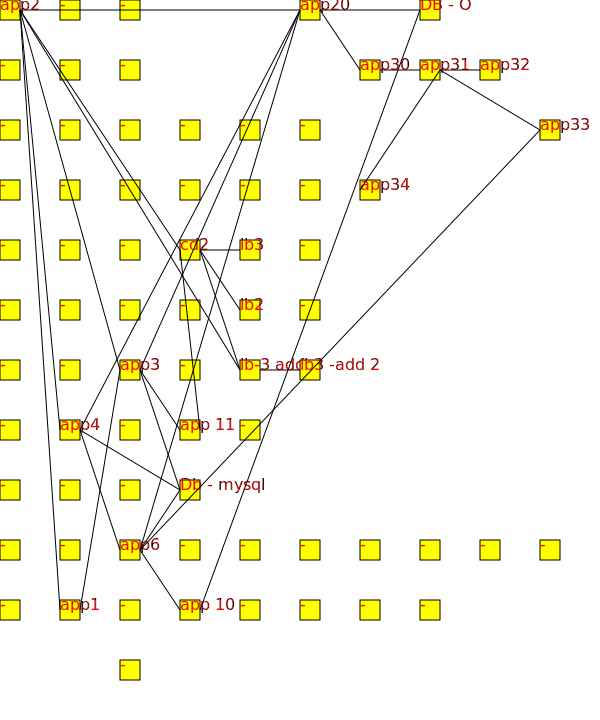

In [5659]:
print("-------------------------")
Orchestration = GridOrchestrator(G)
Orchestration.create(entries)

Layout = DrawLayout(Orchestration.get_grid())
Layout.draw_nodes()
Layout.draw_connections(G.edges())
Layout.save()

print(Orchestration.get_grid().get_grid())
print(Orchestration.get_grid()._index)
   
display(SVG(filename='test.svg'))